In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

Longtime Kagglers will recognize that this competition objective is similar to the ECML/PKDD trip time challenge we hosted in 2015. But, this challenge comes with a twist. Instead of awarding prizes to the top finishers on the leaderboard, this playground competition was created to reward collaboration and collective learning.

We are encouraging you (with cash prizes!) to publish additional training data that other participants can use for their predictions. We also have designated bi-weekly and final prizes to reward authors of kernels that are particularly insightful or valuable to the community.

# Import


In [120]:
import numpy as np
import pandas as pd

import os
from pathlib import Path

# importer la lib pour cross valider le model
from sklearn.model_selection import cross_val_score

# importer la lib pour la regression de Random Forest
from sklearn.ensemble import RandomForestRegressor

# importer la lib pour la regression de Random Forest
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# 1. Data loading

In [121]:
#train = pd.read_csv('training/train.csv')
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')


In [122]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [123]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# 2. Data exploration

In [125]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [126]:
train.trip_duration.min()


1

In [127]:
train.trip_duration.max()

3526282

Dans 1 minute, il y a 60 secondes  
Dans 1 heure, il y a 60 minutes. donc 60 * 60= 3600secondes  
Dans 1 journée, il y a 24 heures. donc 24*3600= 86400 secondes.  
=> 3526282/86400 = 40,81344907 jours


On peut voir qu'il y a un temps de trajet minimum de 1 seconde et un maximum de 40 jours.
Il faudra les enlever car cela va fausser les résultats.  
Dans mon cas, je juge qu'un temps de trajet dans un taxi doit être comprise entre 5 minutes et quelques heures.

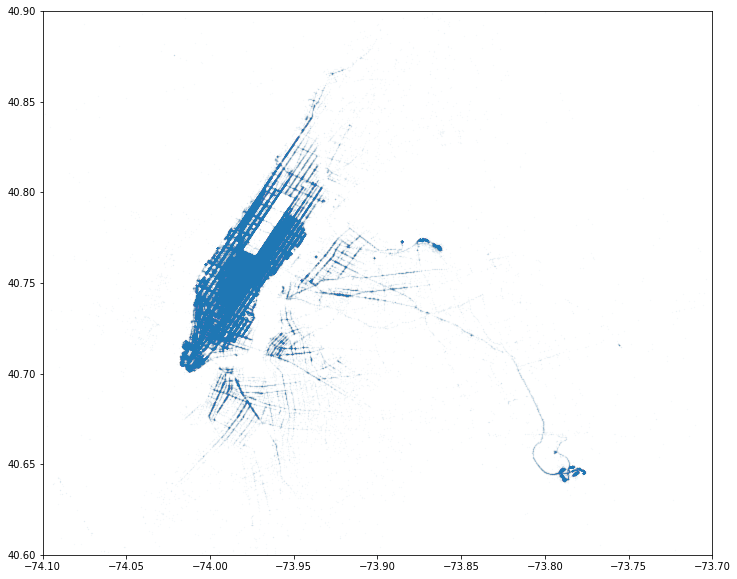

In [128]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.0002, alpha=1)

# 3. Data preprocessing :

#### 3.1 Gestion des Outliers

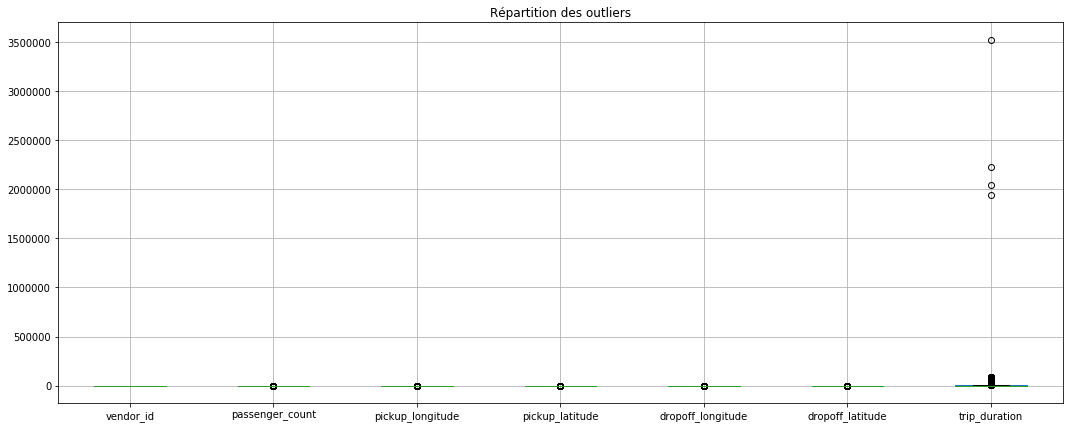

In [129]:
plt.subplots(figsize=(18,7))
plt.title("Répartition des outliers")
train.boxplot()

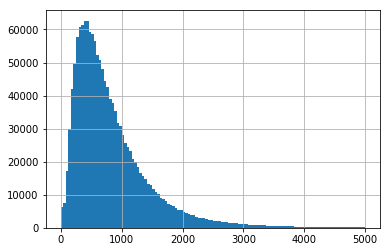

In [130]:
train.loc[train.trip_duration<5000,"trip_duration"].hist(bins=120
                                                        )

On pourra choisir un trip_duration max (3800) et trip_duration_min (0 car les trip_durations peuvent être nulls ou annulées)

In [131]:
train = train[train['trip_duration']<= 3800]

In [132]:
train = train[(train['trip_duration'] > 60) & (train['trip_duration'] < 3600 * 24)]

train['hour'] = train['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

train['dist'] = np.sqrt((train['pickup_latitude']-train['dropoff_latitude'])**2
                        + (train['pickup_longitude']-train['dropoff_longitude'])**2)

test['hour'] = test['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

test['dist'] = np.sqrt((test['pickup_latitude']-test['dropoff_latitude'])**2
                        + (test['pickup_longitude']-test['dropoff_longitude'])**2)

#### 3.2 Missing values handling

In [133]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
hour                  0
dist                  0
dtype: int64

#### 3.4 Scaling des données

# 4. Features engineering : selection, extraction, creation

In [134]:
col_diff = list(set(train.columns).difference(set(test.columns)))

In [135]:
y_train = train["trip_duration"] # <-- target
X_train = train[["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","dist","hour"]] # <-- features

X_datatest = test[["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","dist","hour"]]

In [136]:
train.drop(['dist','hour']+col_diff, axis=1, inplace=True)

# 5. Sélection de modèles et/ou datasets (si il y en a plusieurs)****

In [137]:
# declarer le model et l'entrainer

sgd = SGDRegressor()
sgd.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# 6. Entrainement du ou des modèle(s) & Predictions

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)

In [139]:
knn = RandomForestRegressor(n_estimators=19, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=80, bootstrap=True)
knn.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [140]:
# Trop long
# calculer les scores de cross validation du model selon une decoupe du dataset de train
cv = ShuffleSplit(n_splits=4, test_size=0.8, random_state=42)
cv_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring= 'neg_mean_squared_log_error')

In [141]:
cv_scores

array([-0.13725224, -0.13693262, -0.13807876, -0.13673273])

In [142]:
for i in range(len(cv_scores)):
    cv_scores[i] = np.sqrt(abs(cv_scores[i]))
print(np.mean(cv_scores))

0.37047079375444736


In [143]:
train_pred = knn.predict(X_datatest)

In [144]:
train_pred

array([ 872.22769424,  644.13879644,  420.97961381, ..., 1429.31911028,
       1985.8225515 , 1267.62362792])

In [145]:
len(train_pred)

625134

In [146]:
sample.shape[0]

625134

In [147]:
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': train_pred})
print(my_submission)

               id  trip_duration
0       id3004672     872.227694
1       id3505355     644.138796
2       id1217141     420.979614
3       id2150126    1010.108182
4       id1598245     398.983216
5       id0668992    1017.891232
6       id1765014    1081.357479
7       id0898117     823.321820
8       id3905224    2212.320336
9       id1543102     533.138359
10      id3024712     905.215915
11      id3665810     367.413967
12      id1836461     367.064077
13      id3457080     584.344022
14      id3376065    1115.696611
15      id3008739     675.212695
16      id0902216    1088.643705
17      id3564824     513.890835
18      id0820280     171.317965
19      id0775088    1048.404485
20      id1468488     367.935808
21      id2657479     286.542327
22      id1262719     652.622164
23      id1345524    1157.768050
24      id2911638     938.961779
25      id2849512    1218.339392
26      id0236829     419.367741
27      id2905906     454.950665
28      id3737939     966.383939
29      id

In [ ]:
my_submission.to_csv('submission.csv', index=False)